# Carregar e visualizar os dados

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



gastos_df = pd.read_excel("Gastos_2019.xlsx")
ideb_df = pd.read_excel("IDEB_2019.xlsx", skiprows=4)


print(" Primeiras linhas da tabela de gastos:")
display(gastos_df.head())

print(" Primeiras linhas da tabela do IDEB:")
display(ideb_df.head())


 Primeiras linhas da tabela de gastos:


,Município,COD_MUN,UF,População,Tipo de gasto,Valor do gasto (R$)
0,Prefeitura Municipal de Barra Funda - RS,4301958,RS,2527,12.361 - Ensino Fundamental,2022402.92
1,Prefeitura Municipal de S„o JosÈ do HortÍncio ...,4318481,RS,4739,12.361 - Ensino Fundamental,3855329.33
2,Prefeitura Municipal de TrÍs Cachoeiras - RS,4321667,RS,10989,12.361 - Ensino Fundamental,6953024.50
3,Prefeitura Municipal de Presidente Kubitschek ...,3153301,MG,3004,12.361 - Ensino Fundamental,2208341.11
4,Prefeitura Municipal de Santo AntÙnio das Miss...,4317707,RS,10305,12.361 - Ensino Fundamental,7019579.10


 Primeiras linhas da tabela do IDEB:


,Código do Município,Nome do Município,Rede,Nota SAEB - 2019,Unnamed: 4,Unnamed: 5,IDEB\n2019\n(N x P),Unnamed: 7
0,NaN,NaN,NaN,Matemática,Língua Portuguesa,Nota Média Padronizada (N),NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
2,CO_MUNICIPIO,NO_MUNICIPIO,REDE,VL_NOTA_MATEMATICA_2019,VL_NOTA_PORTUGUES_2019,VL_NOTA_MEDIA_2019,VL_OBSERVADO_2019,VL_PROJECAO_2019
3,1100015,Alta Floresta D'Oeste,Municipal,196.64,180.19,4.992906,4.7,5.5
4,1100023,Ariquemes,Municipal,212.41,197.65,5.611315,5.1,5.5


# Filtrar municípios da Bahia nos dados de gasto

In [34]:

gastos_ba = gastos_df[gastos_df['UF'] == 'BA'].copy()


gastos_ba['População'] = pd.to_numeric(gastos_ba['População'], errors='coerce')


gastos_ba['Gasto_per_capita'] = gastos_ba['Valor do gasto (R$)'] / gastos_ba['População']


print(" Municípios da Bahia com gasto per capita calculado:")
display(gastos_ba[['Município', 'COD_MUN', 'Gasto_per_capita']].head())


 Municípios da Bahia com gasto per capita calculado:


,Município,COD_MUN,Gasto_per_capita
142,Prefeitura Municipal de Ibicoara - BA,2912202,854.105543
283,Prefeitura Municipal de Santa InÍs - BA,2927903,485.684404
1039,Prefeitura Municipal de Bonito - BA,2904050,1038.272464
1056,Prefeitura Municipal de Iramaia - BA,2914307,1055.894279
1074,Prefeitura Municipal de Ichu - BA,2913309,617.602728


# Limpeza de dados

In [35]:

ideb_df.columns = ideb_df.iloc[2]
ideb_df = ideb_df[3:].copy()


ideb_df = ideb_df.rename(columns={
    'CO_MUNICIPIO': 'COD_MUN',
    'NO_MUNICIPIO': 'Município',
    'REDE': 'Rede',
    'VL_OBSERVADO_2019': 'IDEB_2019'
})


ideb_municipal = ideb_df[ideb_df['Rede'] == 'Municipal'].copy()


ideb_municipal['COD_MUN'] = pd.to_numeric(ideb_municipal['COD_MUN'], errors='coerce')
ideb_municipal['IDEB_2019'] = pd.to_numeric(ideb_municipal['IDEB_2019'], errors='coerce')


cods_ba = gastos_ba['COD_MUN'].unique()
ideb_ba = ideb_municipal[ideb_municipal['COD_MUN'].isin(cods_ba)].copy()


print(" IDEB dos municípios da Bahia (rede municipal):")
display(ideb_ba[['Município', 'COD_MUN', 'IDEB_2019']].head())


 IDEB dos municípios da Bahia (rede municipal):


2,Município,COD_MUN,IDEB_2019
1826,Abaíra,2900108,5.5
1827,Abaré,2900207,5.5
1828,Acajutiba,2900306,3.8
1829,Adustina,2900355,5.0
1830,Água Fria,2900405,4.2


# Juntar dados de gasto e IDEB

In [36]:

dados_dea = pd.merge(gastos_ba[['COD_MUN', 'Município', 'Gasto_per_capita']],
                     ideb_ba[['COD_MUN', 'IDEB_2019']],
                     on='COD_MUN')


dados_dea = dados_dea.dropna(subset=['Gasto_per_capita', 'IDEB_2019'])

dados_dea.reset_index(drop=True, inplace=True)



display(dados_dea.head())


,COD_MUN,Município,Gasto_per_capita,IDEB_2019
0,2912202,Prefeitura Municipal de Ibicoara - BA,854.105543,4.5
1,2927903,Prefeitura Municipal de Santa InÍs - BA,485.684404,5.0
2,2904050,Prefeitura Municipal de Bonito - BA,1038.272464,5.2
3,2914307,Prefeitura Municipal de Iramaia - BA,1055.894279,4.4
4,2913309,Prefeitura Municipal de Ichu - BA,617.602728,4.9


In [37]:
import pulp

def run_dea_output_oriented(inputs, outputs, rts='crs'):
    n_dmus = inputs.shape[0]
    scores = []

    for i in range(n_dmus):
        prob = pulp.LpProblem(f"DEA_{i}", pulp.LpMaximize)

        lambdas = [pulp.LpVariable(f"lambda_{j}", lowBound=0) for j in range(n_dmus)]
        theta = pulp.LpVariable("theta", lowBound=0)

        # Maximizar theta
        prob += theta

        # Restrição de output
        prob += pulp.lpSum([lambdas[j] * outputs[j][0] for j in range(n_dmus)]) >= theta * outputs[i][0]

        # Restrições de input
        for k in range(inputs.shape[1]):
            prob += pulp.lpSum([lambdas[j] * inputs[j][k] for j in range(n_dmus)]) <= inputs[i][k]

        # Retornos variáveis de escala
        if rts == 'vrs':
            prob += pulp.lpSum(lambdas) == 1

        # Resolver
        prob.solve(pulp.PULP_CBC_CMD(msg=0))

        # Score final = 1 / θ
        if prob.status == pulp.LpStatusOptimal and pulp.value(theta) != 0:
            scores.append(1 / pulp.value(theta))
        else:
            scores.append(None)

    return np.array(scores)


# Calcular com a função

In [38]:
inputs = dados_dea['Gasto_per_capita'].values.reshape(-1, 1)
outputs = dados_dea['IDEB_2019'].values.reshape(-1, 1)
labels = dados_dea['Município'].values

In [39]:

scores_crs = run_dea_output_oriented(inputs, outputs, rts='crs')
scores_vrs = run_dea_output_oriented(inputs, outputs, rts='vrs')


dados_dea['Score_CRS'] = scores_crs
dados_dea['Score_VRS'] = scores_vrs

display(dados_dea[['Município', 'Gasto_per_capita', 'IDEB_2019', 'Score_CRS', 'Score_VRS']])


,Município,Gasto_per_capita,IDEB_2019,Score_CRS,Score_VRS
0,Prefeitura Municipal de Ibicoara - BA,854.105543,4.5,0.004284,0.635802
1,Prefeitura Municipal de Santa InÍs - BA,485.684404,5.0,0.008370,0.778178
2,Prefeitura Municipal de Bonito - BA,1038.272464,5.2,0.004072,0.712329
3,Prefeitura Municipal de Iramaia - BA,1055.894279,4.4,0.003388,0.602740
4,Prefeitura Municipal de Ichu - BA,617.602728,4.9,0.006451,0.732723
...,...,...,...,...,...
378,Prefeitura Municipal de AndaraÌ - BA,714.444026,5.9,0.006715,0.857582
379,Prefeitura Municipal de Caatiba - BA,727.678718,5.4,0.006034,0.782131
380,Prefeitura Municipal de Barra da Estiva - BA,630.363025,6.0,0.007739,0.893823
381,Prefeitura Municipal de Rio do AntÙnio - BA,837.394817,5.3,0.005146,0.751267


# Top 10 municipios 

In [40]:

top10_crs = dados_dea.sort_values(by='Score_CRS', ascending=False).head(10)
print(" Top 10 municípios mais eficientes (CRS):")
display(top10_crs[['Município', 'Score_CRS']])

bottom10_crs = dados_dea.sort_values(by='Score_CRS', ascending=True).head(10)
print(" Top 10 municípios menos eficientes (CRS):")
display(bottom10_crs[['Município', 'Score_CRS']])


top10_vrs = dados_dea.sort_values(by='Score_VRS', ascending=False).head(10)
print(" Top 10 municípios mais eficientes (VRS):")
display(top10_vrs[['Município', 'Score_VRS']])


bottom10_vrs = dados_dea.sort_values(by='Score_VRS', ascending=True).head(10)
print(" Top 10 municípios menos eficientes (VRS):")
display(bottom10_vrs[['Município', 'Score_VRS']])


 Top 10 municípios mais eficientes (CRS):


,Município,Score_CRS
272,Prefeitura Municipal de Campo Alegre de Lourde...,1.000000
35,Prefeitura Municipal de Santo AntÙnio de Jesus...,0.728394
353,Prefeitura Municipal de Ipir· - BA,0.288616
194,Prefeitura Municipal de Antas - BA,0.256960
329,Prefeitura Municipal de Saubara - BA,0.249919
252,Prefeitura Municipal de Almadina - BA,0.222889
191,Prefeitura Municipal de Jeremoabo - BA,0.090079
200,Prefeitura Municipal de Teol‚ndia - BA,0.083088
291,Prefeitura Municipal de Nova Itarana - BA,0.067699
53,Prefeitura Municipal de Boquira - BA,0.065112


 Top 10 municípios menos eficientes (CRS):


,Município,Score_CRS
217,Prefeitura Municipal de Maetinga - BA,0.001879
363,Prefeitura Municipal de CaÈm - BA,0.002113
184,Prefeitura Municipal de JucuruÁu - BA,0.002120
306,Prefeitura Municipal de Angical - BA,0.002294
202,Prefeitura Municipal de Jita˙na - BA,0.002458
69,Prefeitura Municipal de MuquÈm de S„o Francisc...,0.002486
315,Prefeitura Municipal de Lafaiete Coutinho - BA,0.002486
269,Prefeitura Municipal de Quijingue - BA,0.002506
313,Prefeitura Municipal de Apuarema - BA,0.002578
294,Prefeitura Municipal de Formosa do Rio Preto - BA,0.002619


 Top 10 municípios mais eficientes (VRS):


,Município,Score_VRS
215,Prefeitura Municipal de LicÌnio de Almeida - BA,1.000000
291,Prefeitura Municipal de Nova Itarana - BA,1.000000
169,Prefeitura Municipal de Pojuca - BA,1.000000
35,Prefeitura Municipal de Santo AntÙnio de Jesus...,1.000000
251,Prefeitura Municipal de Itatim - BA,1.000000
272,Prefeitura Municipal de Campo Alegre de Lourde...,1.000000
329,Prefeitura Municipal de Saubara - BA,1.000000
275,Prefeitura Municipal de Wagner - BA,0.936467
57,Prefeitura Municipal de IrecÍ - BA,0.933114
105,Prefeitura Municipal de CaculÈ - BA,0.930530


 Top 10 municípios menos eficientes (VRS):


,Município,Score_VRS
371,Prefeitura Municipal de ItambÈ - BA,0.465753
188,Prefeitura Municipal de AratuÌpe - BA,0.470390
236,Prefeitura Municipal de Esplanada - BA,0.503745
331,Prefeitura Municipal de Itapebi - BA,0.506849
253,Prefeitura Municipal de Cabaceiras do ParaguaÁ...,0.506849
77,Prefeitura Municipal de Mascote - BA,0.506849
118,Prefeitura Municipal de Arataca - BA,0.506849
335,Prefeitura Municipal de Nova Cana„ - BA,0.524289
131,Prefeitura Municipal de Lajedinho - BA,0.527125
308,Prefeitura Municipal de Conde - BA,0.534247


- **Municípios eficientes (Score = 1.000)** indicam **gestão otimizada** dos recursos educacionais, servindo como **referência para boas práticas**.
- **Municípios com baixa eficiência** podem precisar **revisar políticas educacionais** para melhorar o IDEB sem aumentar excessivamente os gastos.
- **Comparação entre CRS e VRS** mostra diferenças de escala, sugerindo que alguns municípios podem estar **subutilizando seus investimentos** ou **necessitando ajustes na gestão**.

- Esses resultados podem auxiliar gestores públicos na **tomada de decisões** para aprimorar políticas educacionais e aumentar a eficiência da aplicação dos recursos.




# Preparação dos dados

In [41]:

dados_dea['IDEB_ideal_CRS'] = dados_dea['IDEB_2019'] / dados_dea['Score_CRS']
dados_dea['IDEB_ideal_VRS'] = dados_dea['IDEB_2019'] / dados_dea['Score_VRS']

dados_dea['Delta_IDEB_CRS'] = dados_dea['IDEB_ideal_CRS'] - dados_dea['IDEB_2019']
dados_dea['Delta_IDEB_VRS'] = dados_dea['IDEB_ideal_VRS'] - dados_dea['IDEB_2019']


top_delta_crs = dados_dea.sort_values(by='Delta_IDEB_CRS', ascending=False).head(10)
top_delta_vrs = dados_dea.sort_values(by='Delta_IDEB_VRS', ascending=False).head(10)

print(" Municípios que mais precisam melhorar o IDEB (CRS):")
display(top_delta_crs[['Município', 'IDEB_2019', 'IDEB_ideal_CRS', 'Delta_IDEB_CRS']])

print(" Municípios que mais precisam melhorar o IDEB (VRS):")
display(top_delta_vrs[['Município', 'IDEB_2019', 'IDEB_ideal_VRS', 'Delta_IDEB_VRS']])


 Municípios que mais precisam melhorar o IDEB (CRS):


,Município,IDEB_2019,IDEB_ideal_CRS,Delta_IDEB_CRS
217,Prefeitura Municipal de Maetinga - BA,5.3,2821.384457,2816.084457
184,Prefeitura Municipal de JucuruÁu - BA,5.2,2452.846760,2447.646760
315,Prefeitura Municipal de Lafaiete Coutinho - BA,5.3,2132.221058,2126.921058
306,Prefeitura Municipal de Angical - BA,4.8,2092.037568,2087.237568
363,Prefeitura Municipal de CaÈm - BA,4.4,2081.872936,2077.472936
365,Prefeitura Municipal de Barro Preto - BA,5.4,2005.974666,2000.574666
202,Prefeitura Municipal de Jita˙na - BA,4.7,1911.911496,1907.211496
294,Prefeitura Municipal de Formosa do Rio Preto - BA,4.9,1870.815982,1865.915982
248,Prefeitura Municipal de Contendas do Sincor· - BA,5.1,1853.968575,1848.868575
40,Prefeitura Municipal de Wanderley - BA,5.5,1840.934645,1835.434645


 Municípios que mais precisam melhorar o IDEB (VRS):


,Município,IDEB_2019,IDEB_ideal_VRS,Delta_IDEB_VRS
371,Prefeitura Municipal de ItambÈ - BA,3.4,7.300000,3.900000
188,Prefeitura Municipal de AratuÌpe - BA,3.3,7.015454,3.715454
253,Prefeitura Municipal de Cabaceiras do ParaguaÁ...,3.7,7.300000,3.600000
331,Prefeitura Municipal de Itapebi - BA,3.7,7.300000,3.600000
77,Prefeitura Municipal de Mascote - BA,3.7,7.300000,3.600000
118,Prefeitura Municipal de Arataca - BA,3.7,7.300000,3.600000
236,Prefeitura Municipal de Esplanada - BA,3.5,6.947963,3.447963
131,Prefeitura Municipal de Lajedinho - BA,3.8,7.208917,3.408917
21,Prefeitura Municipal de SÌtio do Quinto - BA,3.9,7.300000,3.400000
308,Prefeitura Municipal de Conde - BA,3.9,7.300000,3.400000


- Os municípios listados têm notas significativamente inferiores ao esperado, indicando que os investimentos feitos podem não estar sendo convertidos em melhoria de ensino.
- No modelo CRS, algumas cidades apresentam diferenças extremas, sugerindo que podem estar investindo sem obter retorno proporcional na qualidade educacional.
- No modelo VRS, há municípios que poderiam otimizar seus recursos para alcançar melhores resultados no IDEB, indicando potenciais falhas na gestão.

- Esses dados são cruciais para políticas públicas voltadas à educação, pois destacam quais municípios podem precisar de ações corretivas urgentes. 


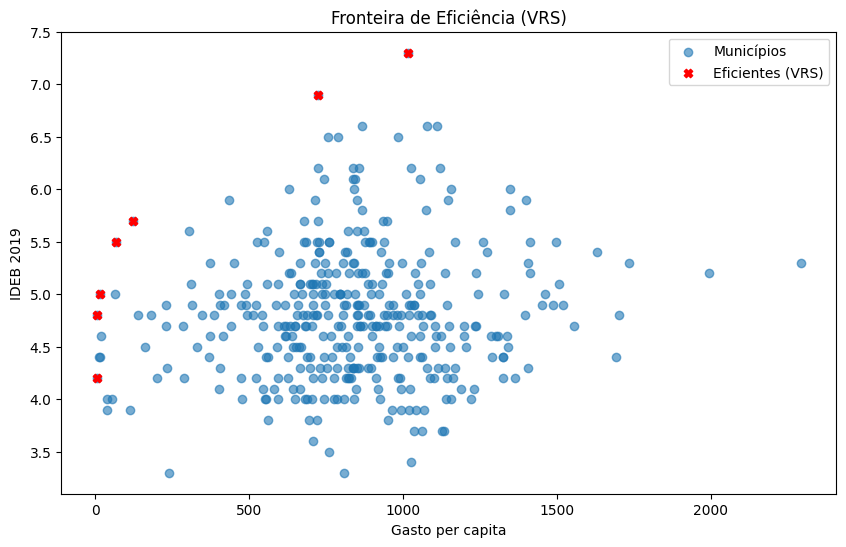

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(dados_dea['Gasto_per_capita'], dados_dea['IDEB_2019'], label='Municípios', alpha=0.6)
eficientes = dados_dea[dados_dea['Score_VRS'] == 1]
plt.scatter(eficientes['Gasto_per_capita'], eficientes['IDEB_2019'], color='red', label='Eficientes (VRS)', marker='X')
plt.xlabel('Gasto per capita')
plt.ylabel('IDEB 2019')
plt.title('Fronteira de Eficiência (VRS)')
plt.legend()
plt.show()


#  O que os dados sugerem?
- Municípios eficientes (estrelas vermelhas) conseguem altos índices no IDEB sem um aumento significativo no gasto per capita.
- Municípios menos eficientes (pontos azuis abaixo da fronteira) podem estar gastando mais sem melhorar proporcionalmente a qualidade educacional.
- Existe uma tendência de que municípios mais eficientes tenham um gasto moderado, maximizando os resultados sem desperdício de recursos.

#  Interpretação:
Este gráfico é fundamental para entender como os investimentos em educação impactam o desempenho escolar. Municípios que gastam muito e ainda têm baixos IDEBs podem precisar de revisão na gestão educacional, enquanto aqueles que atingiram a eficiência podem servir de modelo de boas práticas. 🚀



In [43]:
import pandas as pd
import geopandas as gpd
import unicodedata


dados_eficiencia_crs = {
    "Município": [
        "Maetinga", "Caém", "Jucuruçu", "Angical", "Jitaúna",
        "Muquém de São Francisco", "Lafaiete Coutinho", "Quijingue",
        "Apuarema", "Formosa do Rio Preto"
    ],
    "Score_CRS": [
        0.001879, 0.002113, 0.002120, 0.002294, 0.002458,
        0.002486, 0.002486, 0.002506, 0.002578, 0.002619
    ]
}

dados_eficiencia_vrs = {
    "Município": [
        "Licínio de Almeida", "Nova Itarana", "Pojuca", "Santo Antônio de Jesus", "Itatim",
        "Campo Alegre de Lourde", "Saubara", "Wagner", "Irecí", "Caculê"
    ],
    "Score_VRS": [
        1.000000, 1.000000, 1.000000, 1.000000, 1.000000,
        1.000000, 1.000000, 0.936467, 0.933114, 0.930530
    ]
}


resultados_df_crs = pd.DataFrame(dados_eficiencia_crs)
resultados_df_vrs = pd.DataFrame(dados_eficiencia_vrs)


def padroniza_nome(nome):
    if pd.isnull(nome):
        return ""
    return (
        unicodedata.normalize("NFKD", nome)
        .encode("ASCII", "ignore")
        .decode("utf-8")
        .upper()
        .replace("PREFEITURA MUNICIPAL DE ", "")
        .strip()
    )


resultados_df_crs["Município"] = resultados_df_crs["Município"].apply(padroniza_nome)
resultados_df_vrs["Município"] = resultados_df_vrs["Município"].apply(padroniza_nome)


shapefile_path = "29MUE250GC_SIR.shp"  
mapa_bahia = gpd.read_file(shapefile_path)
mapa_bahia["NM_MUNICIP"] = mapa_bahia["NM_MUNICIP"].apply(padroniza_nome)


# Verificação de colunas

In [44]:

print(dados_dea.head())


print(mapa_bahia["NM_MUNICIP"].head())

municipios_nao_encontrados = dados_dea[~dados_dea["Município"].isin(mapa_bahia["NM_MUNICIP"])]
print(f'Municípios não encontrados: {municipios_nao_encontrados}')


   COD_MUN                                Município  Gasto_per_capita  \
0  2912202    Prefeitura Municipal de Ibicoara - BA        854.105543   
1  2927903  Prefeitura Municipal de Santa InÍs - BA        485.684404   
2  2904050      Prefeitura Municipal de Bonito - BA       1038.272464   
3  2914307     Prefeitura Municipal de Iramaia - BA       1055.894279   
4  2913309        Prefeitura Municipal de Ichu - BA        617.602728   

   IDEB_2019  Score_CRS  Score_VRS  IDEB_ideal_CRS  IDEB_ideal_VRS  \
0        4.5   0.004284   0.635802     1050.462990        7.077679   
1        5.0   0.008370   0.778178      597.342450        6.425266   
2        5.2   0.004072   0.712329     1276.969564        7.300000   
3        4.4   0.003388   0.602740     1298.642620        7.300000   
4        4.9   0.006451   0.732723      759.588543        6.687384   

   Delta_IDEB_CRS  Delta_IDEB_VRS  
0     1045.962990        2.577679  
1      592.342450        1.425266  
2     1271.769564        2.10000

In [45]:
def limpar_nome_municipio(nome):
    nome = nome.replace("Prefeitura Municipal de", "").replace("- BA", "")
    nome = nome.strip().upper()
    nome = nome.replace("Í", "I").replace("Ì", "I").replace("Ú", "U").replace("Ù", "U")
    return nome


dados_dea["Município"] = dados_dea["Município"].apply(limpar_nome_municipio)
mapa_bahia["NM_MUNICIP"] = mapa_bahia["NM_MUNICIP"].str.upper()


In [46]:
mapa_crs = mapa_bahia.merge(dados_dea, left_on="NM_MUNICIP", right_on="Município", how="left")


# Corrigir erro de digitação diretamente na coluna 'Município'

In [47]:

dados_dea["Município"] = dados_dea["Município"].replace(
    {"SANTO ANTUNIO DE JESUS": "SANTO ANTONIO DE JESUS"}
)



# Corrigir acentuação incorreta em ITAMBÈ

In [48]:

dados_dea["Município"] = dados_dea["Município"].replace({"ITAMBÈ": "ITAMBE"})

# GRAFICOS

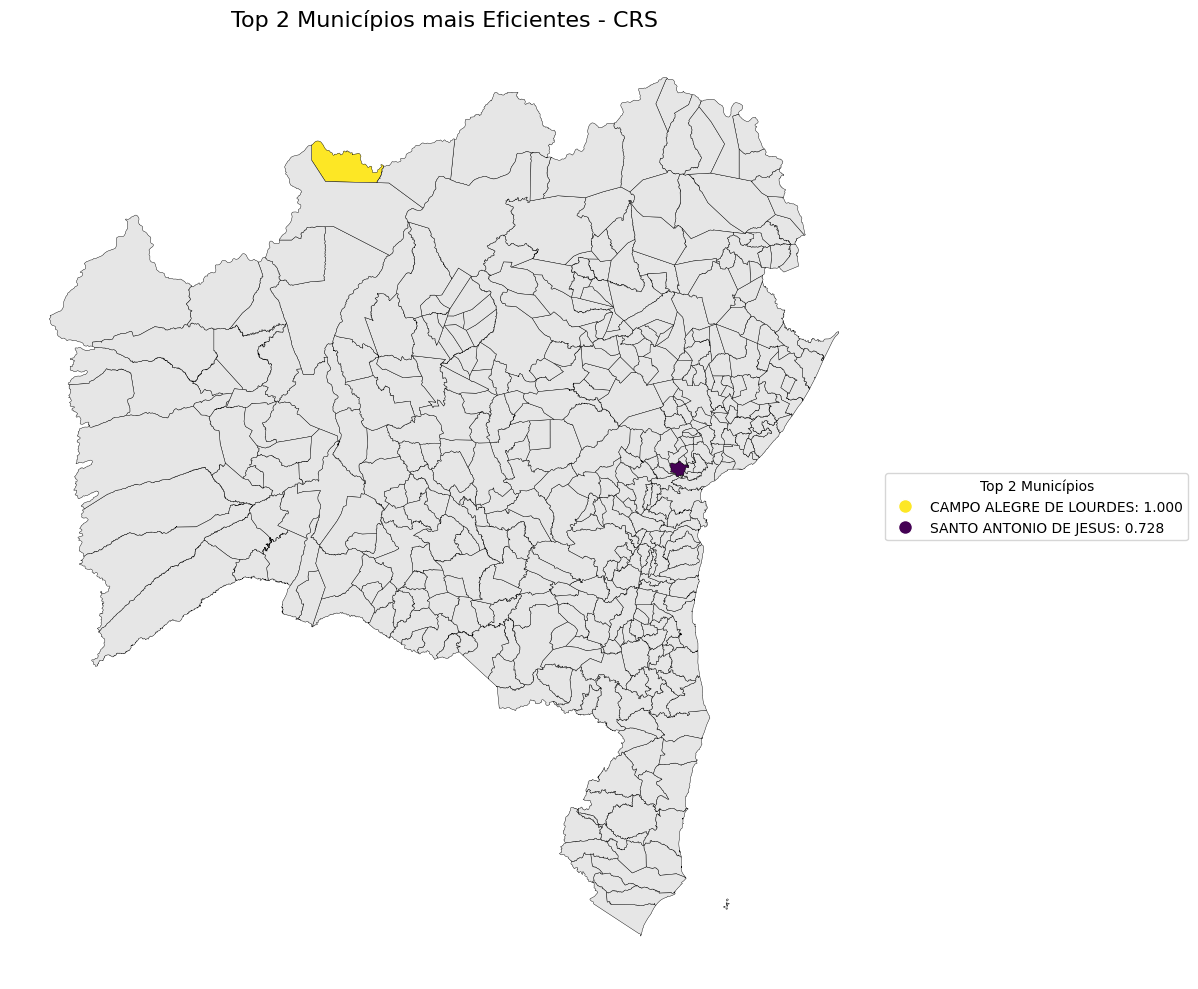

In [49]:
from matplotlib.colors import Normalize
from matplotlib import colormaps
import matplotlib.pyplot as plt


top2_crs = dados_dea.sort_values("Score_CRS", ascending=False).head(2)


mapa_crs = mapa_bahia.merge(dados_dea, left_on="NM_MUNICIP", right_on="Município", how="left")


mapa_crs["is_top2"] = mapa_crs["NM_MUNICIP"].isin(top2_crs["Município"])

norm = Normalize(vmin=top2_crs["Score_CRS"].min(), vmax=top2_crs["Score_CRS"].max())
cmap = colormaps.get_cmap("viridis") 


mapa_crs["color"] = mapa_crs.apply(
    lambda row: cmap(norm(row["Score_CRS"])) if row["is_top2"] else (0.9, 0.9, 0.9, 1), axis=1
)


fig, ax = plt.subplots(1, 1, figsize=(12, 10))
mapa_crs.plot(color=mapa_crs["color"], linewidth=0.3, edgecolor='black', ax=ax)
ax.set_title("Top 2 Municípios mais Eficientes - CRS", fontsize=16)
ax.axis("off")


top2_legenda = mapa_crs[mapa_crs["is_top2"]].sort_values("Score_CRS", ascending=False)
patches = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=f"{row['NM_MUNICIP']}: {row['Score_CRS']:.3f}")
    for _, row in top2_legenda.iterrows()
]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 2 Municípios")
plt.tight_layout()
plt.show()



- Municípios que atingem 1.000 no CRS maximizam seus resultados educacionais sem desperdício de recursos. Santo Antônio de Jesus pode ajustar estratégias educacionais para elevar sua eficiência ao nível de Campo Alegre de Lourdes.


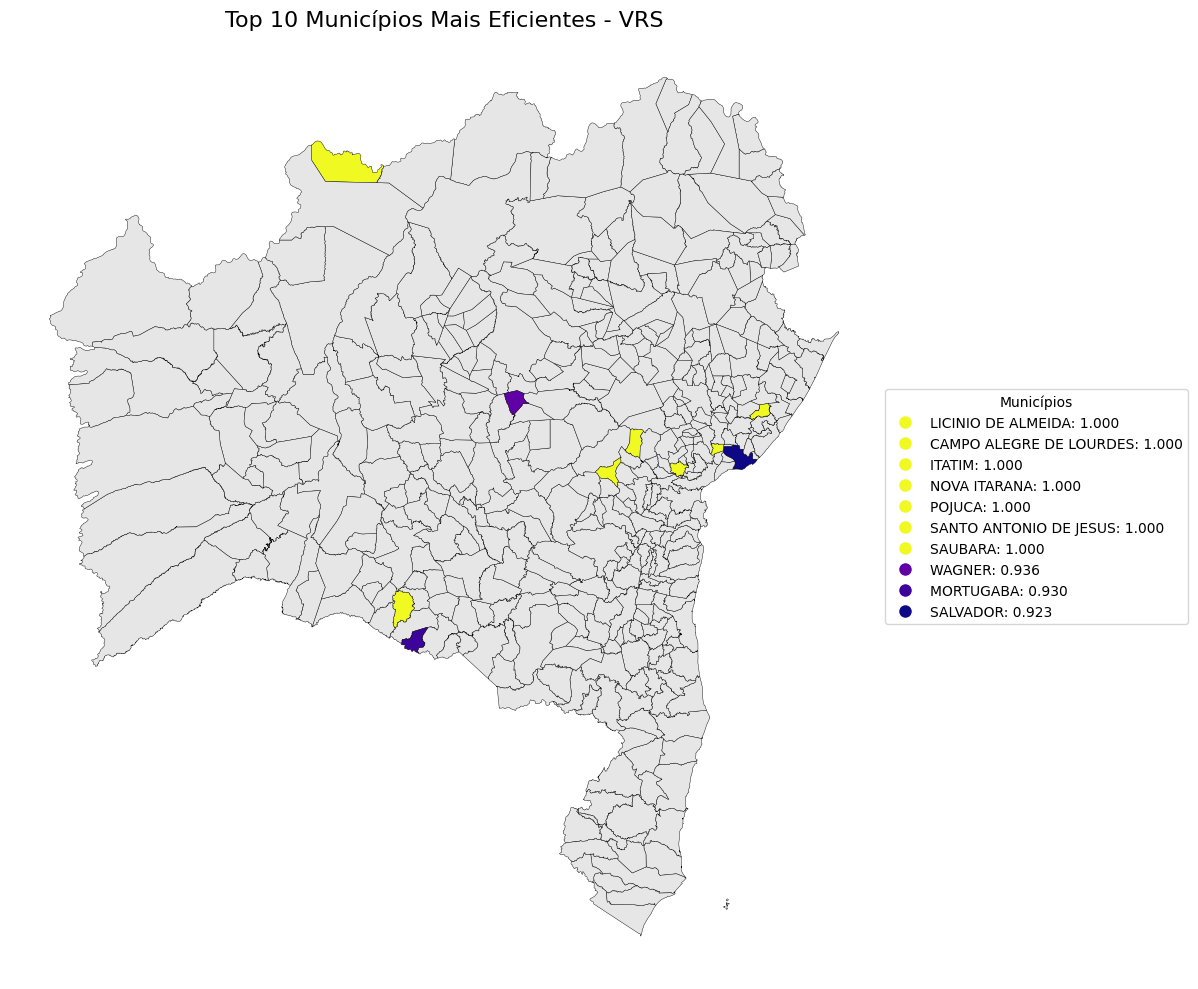

In [50]:
from matplotlib.colors import Normalize
from matplotlib import colormaps
import matplotlib.pyplot as plt


top8_vrs = dados_dea.sort_values("Score_VRS", ascending=False).head(12)


mapa_top_vrs = mapa_bahia.merge(dados_dea, left_on="NM_MUNICIP", right_on="Município", how="left")


mapa_top_vrs["is_top8"] = mapa_top_vrs["NM_MUNICIP"].isin(top8_vrs["Município"])


norm = Normalize(vmin=top8_vrs["Score_VRS"].min(), vmax=top8_vrs["Score_VRS"].max())
cmap = colormaps.get_cmap("plasma") 


mapa_top_vrs["color"] = mapa_top_vrs.apply(
    lambda row: cmap(norm(row["Score_VRS"])) if row["is_top8"] else (0.9, 0.9, 0.9, 1), axis=1
)


fig, ax = plt.subplots(1, 1, figsize=(12, 10))
mapa_top_vrs.plot(color=mapa_top_vrs["color"], linewidth=0.3, edgecolor='black', ax=ax)
ax.set_title("Top 10 Municípios Mais Eficientes - VRS", fontsize=16)
ax.axis("off")


legenda_top_vrs = mapa_top_vrs[mapa_top_vrs["is_top8"]].sort_values("Score_VRS", ascending=False)
patches = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=f"{row['NM_MUNICIP']}: {row['Score_VRS']:.3f}")
    for _, row in legenda_top_vrs.iterrows()
]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Municípios")
plt.tight_layout()
plt.show()



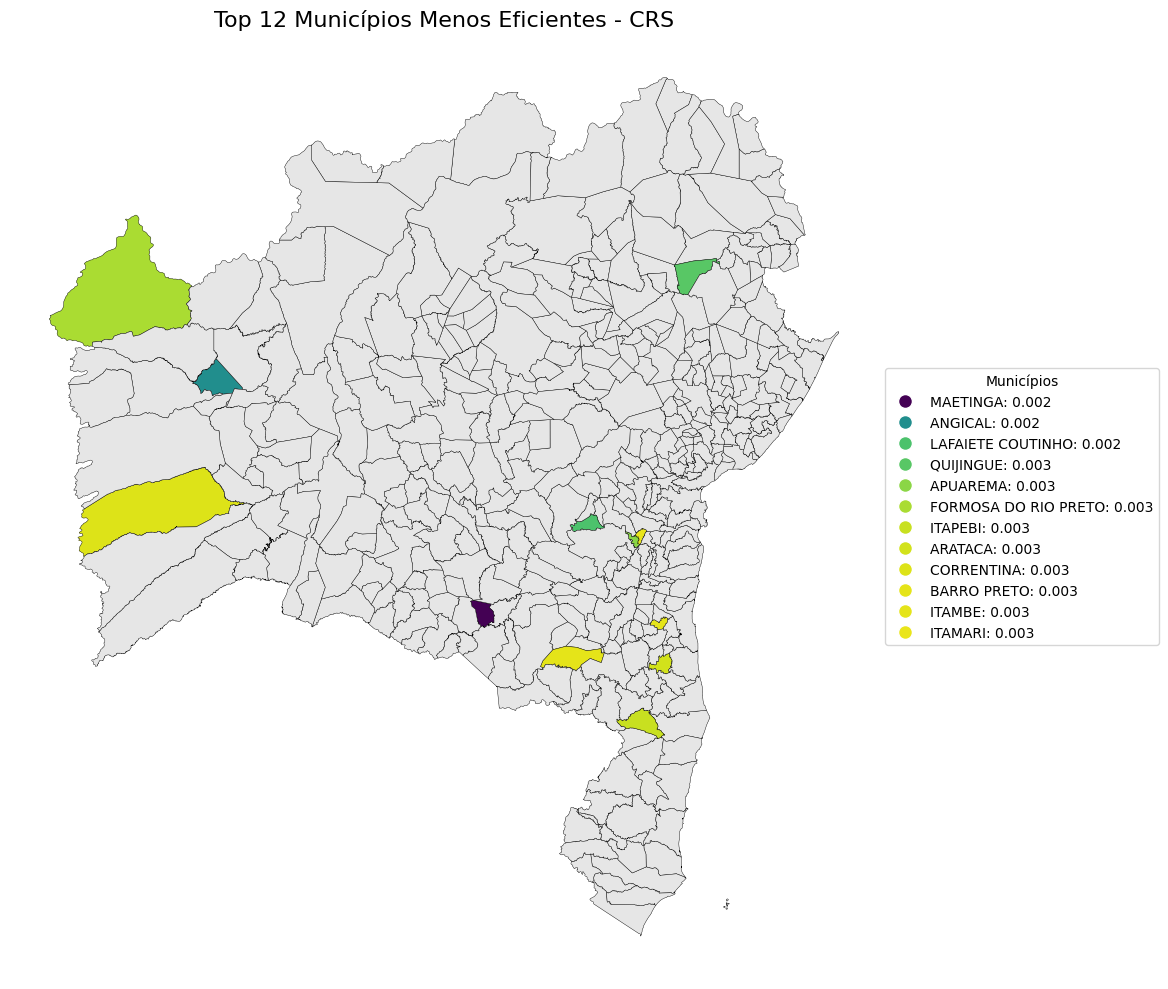

In [51]:
from matplotlib.colors import Normalize
from matplotlib import colormaps
import matplotlib.pyplot as plt


bottom8_crs = dados_dea.sort_values("Score_CRS").head(20)


mapa_bottom_crs = mapa_bahia.merge(dados_dea, left_on="NM_MUNICIP", right_on="Município", how="left")


mapa_bottom_crs["is_bottom8"] = mapa_bottom_crs["NM_MUNICIP"].isin(bottom8_crs["Município"])


norm = Normalize(vmin=bottom8_crs["Score_CRS"].min(), vmax=bottom8_crs["Score_CRS"].max())
cmap = colormaps.get_cmap("viridis")


mapa_bottom_crs["color"] = mapa_bottom_crs.apply(
    lambda row: cmap(norm(row["Score_CRS"])) if row["is_bottom8"] else (0.9, 0.9, 0.9, 1), axis=1
)


fig, ax = plt.subplots(1, 1, figsize=(12, 10))
mapa_bottom_crs.plot(color=mapa_bottom_crs["color"], linewidth=0.3, edgecolor='black', ax=ax)
ax.set_title("Top 12 Municípios Menos Eficientes - CRS", fontsize=16)
ax.axis("off")


legenda_bottom_crs = mapa_bottom_crs[mapa_bottom_crs["is_bottom8"]].sort_values("Score_CRS")
patches = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=f"{row['NM_MUNICIP']}: {row['Score_CRS']:.3f}")
    for _, row in legenda_bottom_crs.iterrows()
]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Municípios")
plt.tight_layout()
plt.show()


#  Top 12 Municípios Menos Eficientes (CRS)
Este mapa destaca os 12 municípios menos eficientes segundo o modelo CRS, mostrando onde os investimentos em educação não estão sendo convertidos em desempenho esperado no IDEB.
## Principais municípios com baixa eficiência:
- Maetinga (Score: 0.002) — O município com menor eficiência CRS, indicando desafios severos na gestão educacional.
- Angical, Lafaiete Coutinho e Quijingue (Scores: entre 0.002 e 0.003) — Municípios que também não conseguem transformar investimentos em melhoria educacional.
- Apuarema, Formosa do Rio Preto e Itapebi (Score: 0.003) — Apresentam baixa eficiência na alocação de recursos, sugerindo necessidade de melhoria estrutural.
- Outros municípios como Arataca, Correntina, Barro Preto, Itambé e Itamari também registram eficiência muito baixa, sugerindo revisão na gestão pública e uso de recursos.

## Interpretação dos Resultados:
- Municípios com Score abaixo de 0.003 precisam de grandes ajustes nas políticas educacionais para evitar desperdício de investimentos.
- A baixa eficiência pode ser resultado de má gestão, infraestrutura precária ou falta de capacitação de professores.
- Esses municípios devem revisar o uso dos recursos públicos, pois altos investimentos sem retorno educacional indicam necessidade de reestruturação.




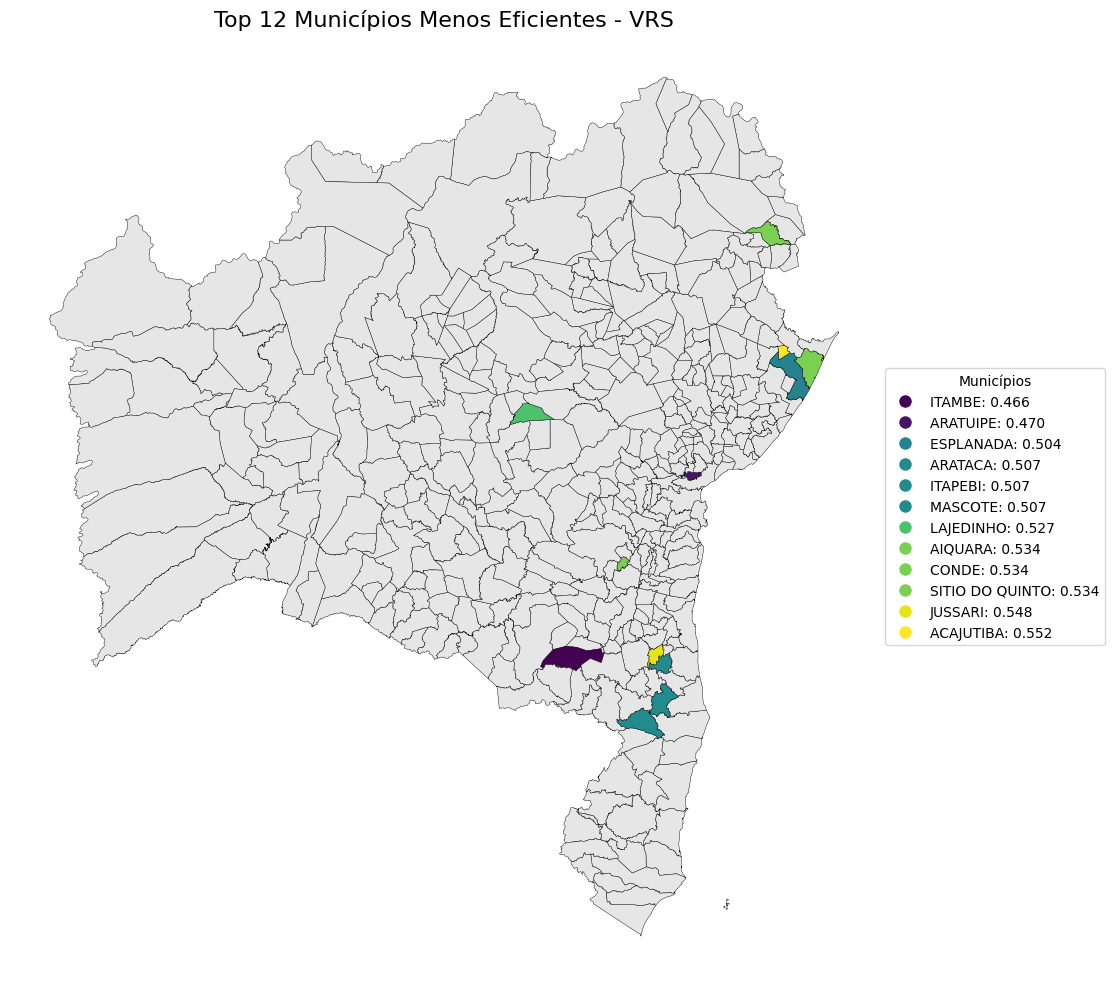

In [52]:

bottom7_vrs = dados_dea.sort_values("Score_VRS").head(18)


mapa_bottom_vrs = mapa_bahia.merge(dados_dea, left_on="NM_MUNICIP", right_on="Município", how="left")


mapa_bottom_vrs["is_bottom7"] = mapa_bottom_vrs["NM_MUNICIP"].isin(bottom7_vrs["Município"])


norm = Normalize(vmin=bottom7_vrs["Score_VRS"].min(), vmax=bottom7_vrs["Score_VRS"].max())
cmap = colormaps.get_cmap("viridis")


mapa_bottom_vrs["color"] = mapa_bottom_vrs.apply(
    lambda row: cmap(norm(row["Score_VRS"])) if row["is_bottom7"] else (0.9, 0.9, 0.9, 1), axis=1
)


fig, ax = plt.subplots(1, 1, figsize=(12, 10))
mapa_bottom_vrs.plot(color=mapa_bottom_vrs["color"], linewidth=0.3, edgecolor='black', ax=ax)
ax.set_title("Top 12 Municípios Menos Eficientes - VRS", fontsize=16)
ax.axis("off")


legenda_bottom_vrs = mapa_bottom_vrs[mapa_bottom_vrs["is_bottom7"]].sort_values("Score_VRS")
patches = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=f"{row['NM_MUNICIP']}: {row['Score_VRS']:.3f}")
    for _, row in legenda_bottom_vrs.iterrows()
]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title="Municípios")
plt.tight_layout()
plt.show()


# Top 12 Municípios Menos Eficientes (VRS)
Este mapa apresenta os 12 municípios menos eficientes segundo o modelo VRS, destacando aqueles que mais precisam otimizar a gestão educacional.
## Principais municípios com baixa eficiência:
- Itambé (Score: 0.466) — O município menos eficiente no modelo VRS, apresentando dificuldades na conversão de recursos em qualidade educacional.
- Aratuípe, Esplanada e Arataca (Scores entre 0.470 e 0.507) — Municípios que mostram baixa eficiência na relação entre investimentos e IDEB, sugerindo necessidade de melhorias na gestão pública.
- Conde, Lajedinho e Aiquara (Scores entre 0.527 e 0.534) — Apesar de apresentarem melhores indicadores que os anteriores, ainda precisam de ajustes para alcançar um nível de eficiência satisfatório.
- Outros municípios como Jussari e Acajutiba (Score entre 0.548 e 0.552) estão próximos de uma gestão mais eficiente, mas ainda precisam otimizar recursos para melhorar o desempenho educacional.

## Interpretação dos Resultados:
- Municípios com baixa eficiência no modelo VRS indicam que os gastos educacionais não estão sendo convertidos em desempenho proporcional.
- Alguns municípios apresentam indicadores melhores que os outros, sugerindo que pequenos ajustes nas políticas educacionais podem resultar em melhoria significativa.
- Esse mapa serve como um diagnóstico para gestores públicos, mostrando onde direcionar esforços para aumentar a eficiência na alocação de recursos educacionais.


